<a href="https://colab.research.google.com/github/harryypham/MyMLPractice/blob/main/LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

In [2]:
def get_mean_and_std(dataset, num_channels):
    """
    Calculate the mean and std of a dataset
    """
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    for inputs, labels in dataloader:
      for channel in range(num_channels):
        mean[channel] += inputs[:,channel,:,:].mean()
        std[channel] += inputs[:,channel,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

#Dummy dataset to get mean and std
temp_dataset = torchvision.datasets.CIFAR10(root="/content/data", train=True, download=True, transform=transforms.ToTensor())
mean, std = get_mean_and_std(temp_dataset, 3)
mean = tuple(mean.numpy())
std = tuple(std.numpy())


transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
train_dataset = torchvision.datasets.CIFAR10(root="/content/data/train", train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root="/content/data/test", train=False, download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:02<00:00, 75989270.77it/s]


Extracting /content/data/cifar-10-python.tar.gz to /content/data


100%|██████████| 170498071/170498071 [00:03<00:00, 45880250.77it/s]


Extracting /content/data/train/cifar-10-python.tar.gz to /content/data/train


100%|██████████| 170498071/170498071 [00:01<00:00, 87880751.72it/s]


Extracting /content/data/test/cifar-10-python.tar.gz to /content/data/test


In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
batch_size = 64
learning_rates = [0.05, 0.01, 0.005, 0.001]
activations = ["relu", "tanh"]
pools = ["max", "average"]
optimizers = ["Adam", "SGD"]
epochs = 10


trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
class LeNet(nn.Module):
  def __init__(self, act_func="relu", pool_type="max"):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6*3, 5)
    self.conv2 = nn.Conv2d(6*3, 16*3, 5)
    self.pool1 = self.pool(pool_type)
    self.pool2 = self.pool(pool_type)
    self.fc1   = nn.Linear(1200, 120)
    self.fc2   = nn.Linear(120, 84)
    self.fc3   = nn.Linear(84, 10)
    self.act_func = act_func
    self.pool_type = pool_type

  def pool(self, pool_type="max"):
    if pool_type == "average":
      return nn.AvgPool2d(2)
    else:
      return nn.MaxPool2d(2)

  def act(self, x, act_func="relu"):
    if act_func == "tanh":
      return F.tanh(x)
    else:
      return F.relu(x)

  def forward(self, x):
    x = self.act(self.conv1(x), self.act_func)
    x = self.pool1(x)
    x = self.act(self.conv2(x), self.act_func)
    x = self.pool2(x)
    x = x.view(x.size(0), -1)
    x = self.act(self.fc1(x), self.act_func)
    x = self.act(self.fc2(x), self.act_func)
    x = self.fc3(x)
    return x

In [5]:
def compute_accuracy_test(model, dataloader, device):
    """
    Compute accuracy on test set
    """
    correct, total = 0, 0
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        _, predict = outputs.max(1)

        total += targets.size(0)
        correct += predict.eq(targets).sum().item()

    return correct/total * 100

In [6]:
def train(model, trainloader, testloader, criterion, optimizer, epochs, device, compute_accuracy_test):
  loss_history, acc_history = [], []
  for epoch in range(epochs):
    print(f'\nEpoch {epoch+1}:')
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predict = outputs.max(1)
        total += targets.size(0)
        correct += predict.eq(targets).sum().item()
        if (not batch_idx % 150) and batch_idx != 0:
              print ('Batch %03d | Cost: %.6f | Accuracy: %.4f'
                    %(batch_idx, train_loss/(batch_idx+1), 100*correct/total))

    loss_history.append(train_loss/(batch_idx+1))
    acc_history.append(100*correct/total)

    model.eval()
    with torch.set_grad_enabled(False):
        test_acc = compute_accuracy_test(net, testloader, device)

  return loss_history, acc_history, test_acc

In [7]:
def subplot_act_pool(axs, idx):
  for key, value in history.items():
    xs = [x+1 for x in range(len(value[idx]))]
    axs.plot(xs, value[idx], label=key+" pool")
  axs.legend()
  axs.set_xlabel("Epoch")
  if idx == 0:
    axs.set_ylabel("Training loss")
  if idx == 1:
    axs.set_ylabel("Accuracy")

def plot_act_pool(history):
  """
  Plot combinations of activation functions and pooling methods
  """
  fig, axs = plt.subplots(1,2, figsize=(12, 5))
  for i in range(2):
    subplot_act_pool(axs[i], i)
  plt.annotate('Train with Adam optimizer using constant learning rate=0.001 and weight decay=5e-4',
              xy = (1.0, -0.2),
              xycoords='axes fraction',
              ha='right',
              va="center",
              fontsize=10)
  fig.show()

def subplot_opt_lr(axs, key, value):
  xs = [x+1 for x in range(10)]
  axs.plot(xs, value["Adam"][0], label="Adam")
  axs.plot(xs, value["SGD"][0], label="SGD with momentum")
  axs.text(xs[-1], value["Adam"][0][-1], '{:.3f}'.format(value["Adam"][0][-1]))
  axs.text(xs[-1], value["SGD"][0][-1], '{:.3f}'.format(value["SGD"][0][-1]))
  axs.legend()
  axs.set_xlabel("Epoch")
  axs.set_ylabel("Training loss")
  axs.set_title(f"Learning rate {key}")

def plot_opt_lr(history):
  """
  Plot combinations of different optimizers and learning rates
  """
  fig, axs = plt.subplots(2,2, figsize=(12, 10))
  for i, (key, value) in enumerate(history.items()):
    subplot_opt_lr(axs[i//2, i%2], key, value)
  fig.show()




Epoch 1:
Batch 150 | Cost: 8.351635 | Accuracy: 10.2752
Batch 300 | Cost: 5.338823 | Accuracy: 10.1692
Batch 450 | Cost: 4.329887 | Accuracy: 10.2134
Batch 600 | Cost: 3.825912 | Accuracy: 10.0068
Batch 750 | Cost: 3.522536 | Accuracy: 10.0262

Epoch 2:
Batch 150 | Cost: 2.307456 | Accuracy: 9.5095
Batch 300 | Cost: 2.336678 | Accuracy: 9.8370
Batch 450 | Cost: 2.327026 | Accuracy: 9.8392
Batch 600 | Cost: 2.321898 | Accuracy: 9.9158
Batch 750 | Cost: 2.318887 | Accuracy: 9.8619

Epoch 3:
Batch 150 | Cost: 2.557796 | Accuracy: 10.2546
Batch 300 | Cost: 2.511336 | Accuracy: 10.3301
Batch 450 | Cost: 2.443240 | Accuracy: 10.2481
Batch 600 | Cost: 2.851185 | Accuracy: 10.6073
Batch 750 | Cost: 2.734288 | Accuracy: 11.2933

Epoch 4:
Batch 150 | Cost: 2.314953 | Accuracy: 10.6374
Batch 300 | Cost: 2.310923 | Accuracy: 10.2159
Batch 450 | Cost: 2.309705 | Accuracy: 10.0437
Batch 600 | Cost: 2.308946 | Accuracy: 10.0198
Batch 750 | Cost: 2.309361 | Accuracy: 9.9388

Epoch 5:
Batch 150 | Cost

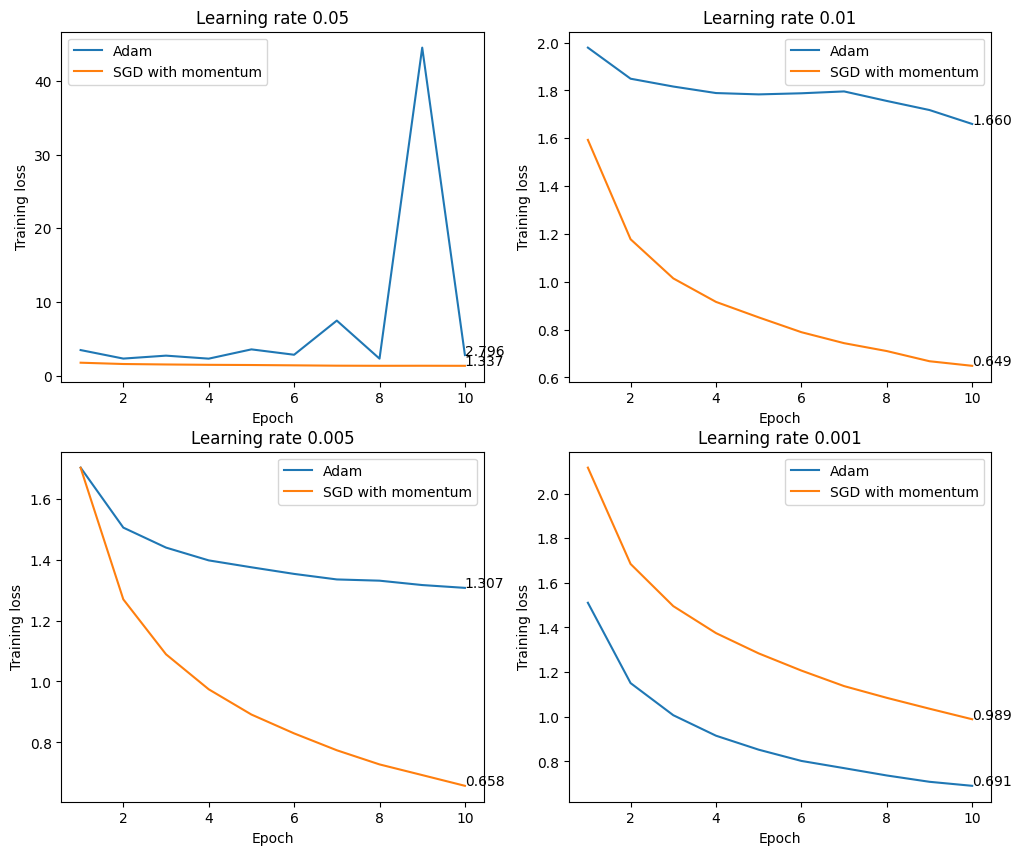

In [8]:
#Compare between different learning rates and optimizers
history = {}
for lr in learning_rates:
  opt_dict = {}
  for opt in optimizers:

    net = LeNet()
    net.to(device)
    if device == "cuda:0":
      net = nn.DataParallel(net)

    if opt == "Adam":
      optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=5e-4)
    if opt == "SGD":
      optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

    criterion = nn.CrossEntropyLoss()
    loss_history, acc_history, test_acc = train(net, trainloader, testloader, criterion, optimizer, epochs, device, compute_accuracy_test)

    opt_dict[opt] = (loss_history, acc_history, test_acc)
  history[str(lr)] = opt_dict

plot_opt_lr(history)


Epoch 1:
Batch 150 | Cost: 1.822349 | Accuracy: 31.6743
Batch 300 | Cost: 1.681956 | Accuracy: 37.7440
Batch 450 | Cost: 1.590407 | Accuracy: 41.4288
Batch 600 | Cost: 1.521406 | Accuracy: 44.4052
Batch 750 | Cost: 1.472577 | Accuracy: 46.3881

Epoch 2:
Batch 150 | Cost: 1.172487 | Accuracy: 58.4748
Batch 300 | Cost: 1.161466 | Accuracy: 58.7780
Batch 450 | Cost: 1.139372 | Accuracy: 59.7215
Batch 600 | Cost: 1.124862 | Accuracy: 60.4461
Batch 750 | Cost: 1.109630 | Accuracy: 60.9604

Epoch 3:
Batch 150 | Cost: 0.994415 | Accuracy: 64.5281
Batch 300 | Cost: 0.986028 | Accuracy: 65.1319
Batch 450 | Cost: 0.984090 | Accuracy: 65.1989
Batch 600 | Cost: 0.975662 | Accuracy: 65.5938
Batch 750 | Cost: 0.971129 | Accuracy: 65.8164

Epoch 4:
Batch 150 | Cost: 0.883890 | Accuracy: 69.3191
Batch 300 | Cost: 0.886953 | Accuracy: 69.0770
Batch 450 | Cost: 0.890233 | Accuracy: 68.8643
Batch 600 | Cost: 0.888478 | Accuracy: 68.9736
Batch 750 | Cost: 0.881899 | Accuracy: 69.1786

Epoch 5:
Batch 150 

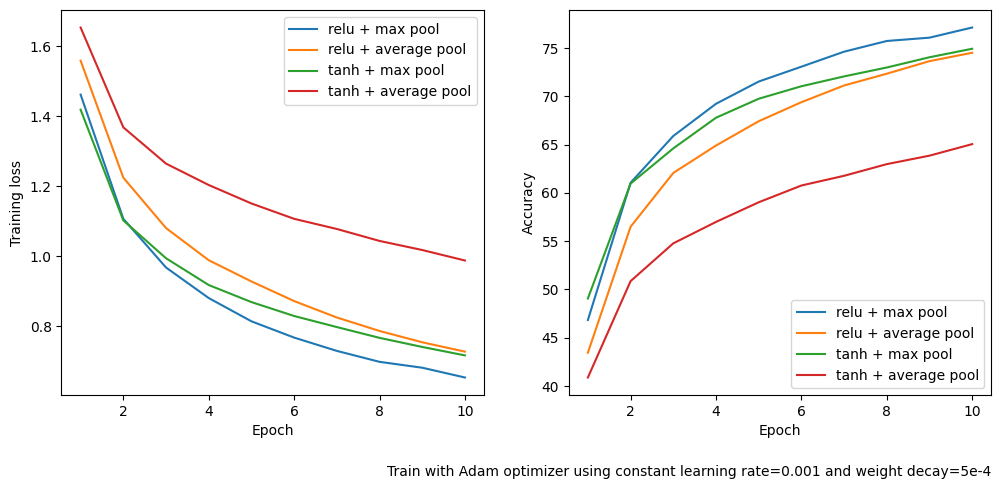

In [11]:
#Compare between different pooling methods and activation functions
history = {}
for activation in activations:
  for pool in pools:
    net = LeNet(act_func=activation, pool_type=pool)
    net.to(device)
    if device == "cuda:0":
      net = nn.DataParallel(net)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rates[3], weight_decay=5e-4)

    loss_history, acc_history, test_acc = train(net, trainloader, testloader, criterion, optimizer, epochs, device, compute_accuracy_test)

    history[f"{activation} + {pool}"] = (loss_history, acc_history, test_acc)

plot_act_pool(history)

In [ ]:
"""
At the moment, I will not spend time finetuning this as this is a small and quite old architecture.
"""